## Installing dependencies

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install --quiet optuna
!pip install TPOT

In [4]:
!pip install xgboost

In [5]:
# importing dependencies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm

import sklearn
from sklearn.ensemble import RandomForestClassifier
from tpot import TPOTClassifier
import xgboost 

from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, RandomizedSearchCV
import optuna
print(optuna.__version__)
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.0.0


## Data reading and EDA + data processing

#### X_train

In [6]:
df_train=pd.read_csv('/content/drive/My Drive/kaggle_data/Dataset/train.csv')
df_train.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [50]:
df_train.issue_date=df_train.issue_date.apply(lambda x:x[:10])
df_train.listing_date=df_train.listing_date.apply(lambda x:x[:10])
df_train[['issue_date','listing_date']]=df_train[['issue_date','listing_date']].apply(pd.to_datetime)
df_train['days']=(df_train['listing_date'] - df_train['issue_date']).dt.days

df_train.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,days
0,ANSL_69903,2016-07-10,2016-09-21,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1,73
1,ANSL_66892,2013-11-21,2018-12-27,1.0,White,0.72,14.19,13,9,0.0,2,1862
2,ANSL_69750,2014-09-28,2016-10-19,NaN,Brown,0.15,40.90,15,4,2.0,4,752
3,ANSL_71623,2016-12-31,2019-01-25,1.0,White,0.62,17.82,0,1,0.0,2,755
4,ANSL_57969,2017-09-28,2017-11-19,2.0,Black,0.50,11.06,18,4,0.0,1,52


In [7]:
Y_breed=df_train.breed_category
Y_pet=df_train.pet_category

In [51]:
df_train.drop(['issue_date','listing_date'], axis=1, inplace=True)

In [66]:
df_train['X12']=df_train.X1*df_train.X2

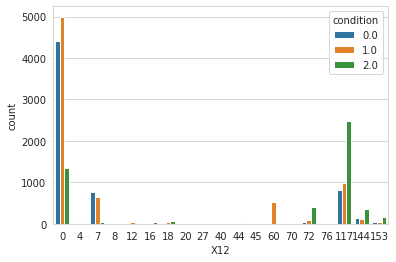

In [67]:
sns.countplot(x='X12', data=df_train, hue='condition')

In [54]:
df_train.fillna(-1.0,inplace=True)

In [55]:
#Filling NAN(-1 here) values
df_train.loc[(df_train['condition']==-1) & (df_train['X12']>70), 'condition']=2.0
df_train.loc[(df_train['condition']==-1) ,'condition']=1.0

In [56]:
df_train['day_per_area']= df_train.days/(df_train['height(cm)']/100.0)*(df_train['length(m)'])

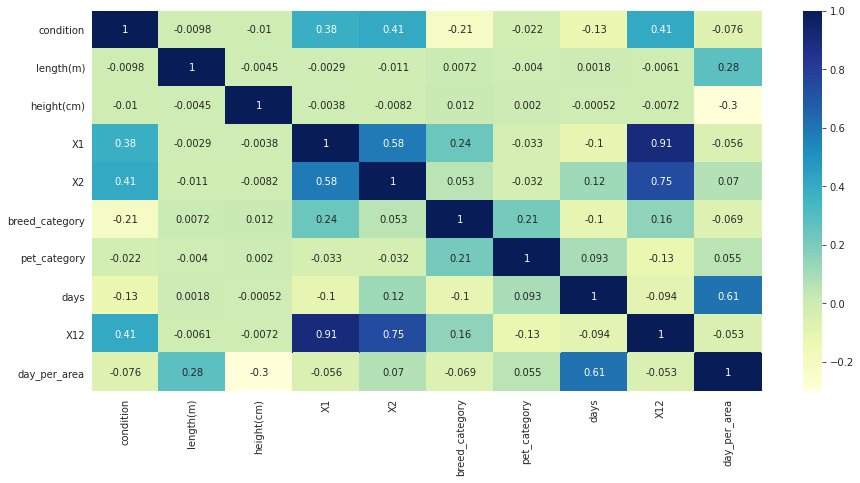

In [57]:
# Correlation 
corr=df_train.corr()
f,ax=plt.subplots(1,1,figsize=(15,7))
sns.heatmap(corr, annot=True, cmap="YlGnBu", ax=ax)

In [60]:
df_train.drop(['X12'], axis=1, inplace=True)
df_train.drop(['length(m)'], axis=1, inplace=True)

In [61]:
X_train=df_train.drop(['pet_id','breed_category','pet_category'], axis=1)
Y_breed=df_train.breed_category
Y_pet=df_train.pet_category

X_train.head()

,condition,color_type,height(cm),X1,X2,days,day_per_area
0,2.0,Brown Tabby,7.78,13,9,73,750.642674
1,1.0,White,14.19,13,9,1862,9447.780127
2,1.0,Brown,40.90,15,4,752,275.794621
3,1.0,White,17.82,0,1,755,2626.823793
4,2.0,Black,11.06,18,4,52,235.081374


### X_test

In [68]:
df_test=pd.read_csv('/content/drive/My Drive/kaggle_data/Dataset/test.csv')
df_test.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2
0,ANSL_75005,2005-08-17 00:00:00,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7
1,ANSL_76663,2018-11-15 00:00:00,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1
2,ANSL_58259,2012-10-11 00:00:00,2018-04-02 16:51:00,1.0,Black,0.24,41.21,0,7
3,ANSL_67171,2015-02-13 00:00:00,2018-04-06 07:25:00,1.0,Black,0.29,8.46,7,1
4,ANSL_72871,2017-01-18 00:00:00,2018-04-26 13:42:00,1.0,Brown,0.71,30.92,0,7


In [69]:
df_test.issue_date= df_test.issue_date.apply(lambda x:x[:10])
df_test.listing_date= df_test.listing_date.apply(lambda x:x[:10])
df_test[['issue_date','listing_date']]= df_test[['issue_date','listing_date']].apply(pd.to_datetime)
df_test['days']= (df_test['listing_date'] - df_test['issue_date']).dt.days

df_test.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,days
0,ANSL_75005,2005-08-17,2017-09-07,0.0,Black,0.87,42.73,0,7,4404
1,ANSL_76663,2018-11-15,2019-05-08,1.0,Orange Tabby,0.06,6.71,0,1,174
2,ANSL_58259,2012-10-11,2018-04-02,1.0,Black,0.24,41.21,0,7,1999
3,ANSL_67171,2015-02-13,2018-04-06,1.0,Black,0.29,8.46,7,1,1148
4,ANSL_72871,2017-01-18,2018-04-26,1.0,Brown,0.71,30.92,0,7,463


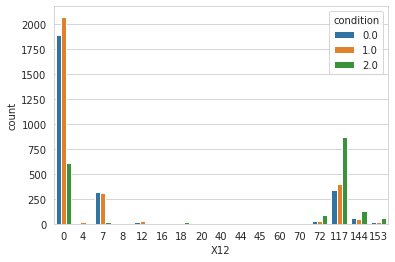

In [70]:
df_test.drop(['issue_date','listing_date'], axis=1, inplace=True)
df_test['X12']=df_test.X1*df_test.X2

sns.countplot(x='X12', data=df_test, hue='condition')

In [71]:
df_test.fillna(-1.0,inplace=True)
#Filling NAN(-1 here) values
df_test.loc[(df_test['condition']==-1) & (df_test['X12']>70), 'condition']=2.0
df_test.loc[(df_test['condition']==-1) ,'condition']=1.0

In [72]:
df_test['day_per_area']= df_test.days/(df_test['height(cm)']/100.0)*(df_test['length(m)'])

In [75]:
df_test.drop(['X12'], axis=1, inplace=True)
df_test.drop(['length(m)'], axis=1, inplace=True)

In [78]:
X_train.head()

,condition,color_type,height(cm),X1,X2,days,day_per_area
0,2.0,Brown Tabby,7.78,13,9,73,750.642674
1,1.0,White,14.19,13,9,1862,9447.780127
2,1.0,Brown,40.90,15,4,752,275.794621
3,1.0,White,17.82,0,1,755,2626.823793
4,2.0,Black,11.06,18,4,52,235.081374


In [ ]:
id=df_test.pet_id
X_test=df_test.drop(['pet_id'], axis=1)
X_test.head()

,condition,color_type,height(cm),X1,X2,days,day_per_area
0,0.0,Black,42.73,0,7,4404,8966.721273
1,1.0,Orange Tabby,6.71,0,1,174,155.588674
2,1.0,Black,41.21,0,7,1999,1164.183451
3,1.0,Black,8.46,7,1,1148,3935.224586
4,1.0,Brown,30.92,0,7,463,1063.163001


In [79]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8072 entries, 0 to 8071
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   condition     8072 non-null   float64
 1   color_type    8072 non-null   object 
 2   height(cm)    8072 non-null   float64
 3   X1            8072 non-null   int64  
 4   X2            8072 non-null   int64  
 5   days          8072 non-null   int64  
 6   day_per_area  8072 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 441.6+ KB


In [ ]:
df_train.issue_date=df_train.issue_date.apply(lambda x:x[:7])
df_train.listing_date=df_train.listing_date.apply(lambda x:x[:7])

def date_plot(factor, target, rot=True):
    list_dt=df_train.groupby([factor])[target].value_counts()
    list_dt=pd.DataFrame(list_dt)
    list_dt.rename(columns={target:'count'}, inplace=True)
    
    list_dt.reset_index(level=[0,1], inplace=True)
    if rot:
        plt.figure(figsize=(32,8))
        sns.barplot(x=factor,y='count', data=list_dt.loc[8:], hue=target)
    else:
        plt.figure(figsize=(12,25))
        sns.barplot(x='count',y=factor, data=list_dt.loc[235:], hue=target)

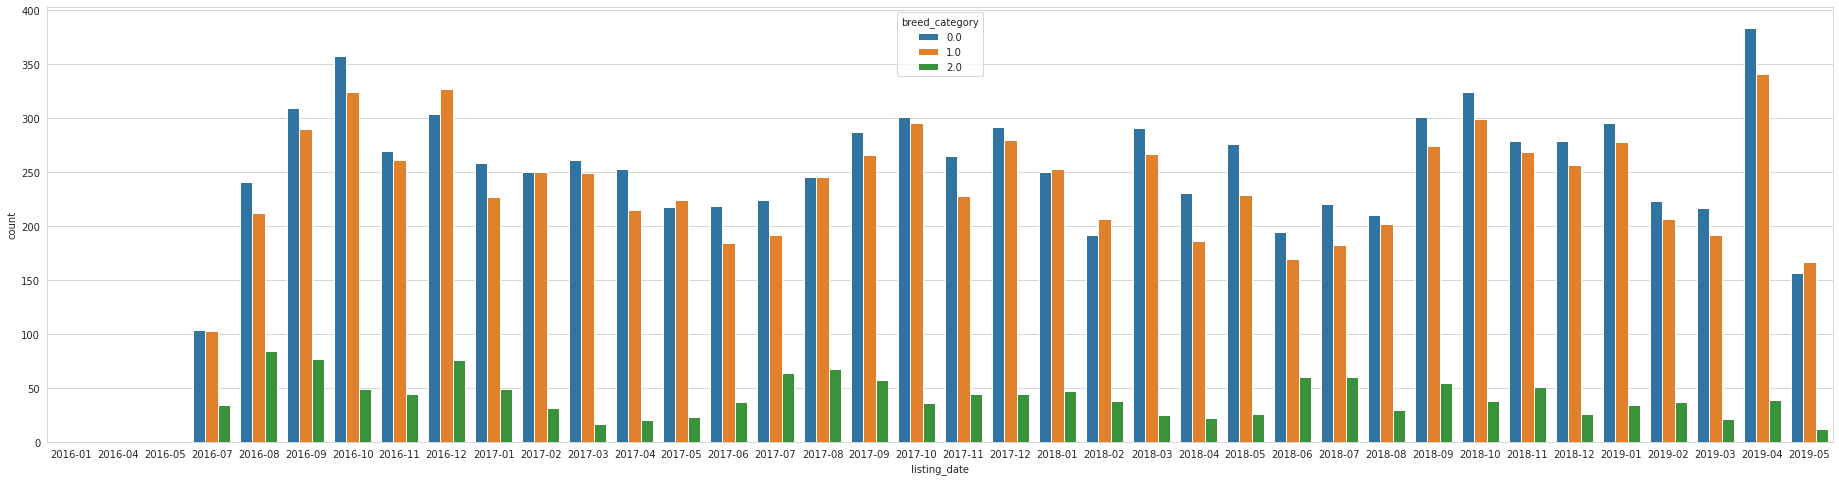

In [ ]:
date_plot('listing_date','breed_category')

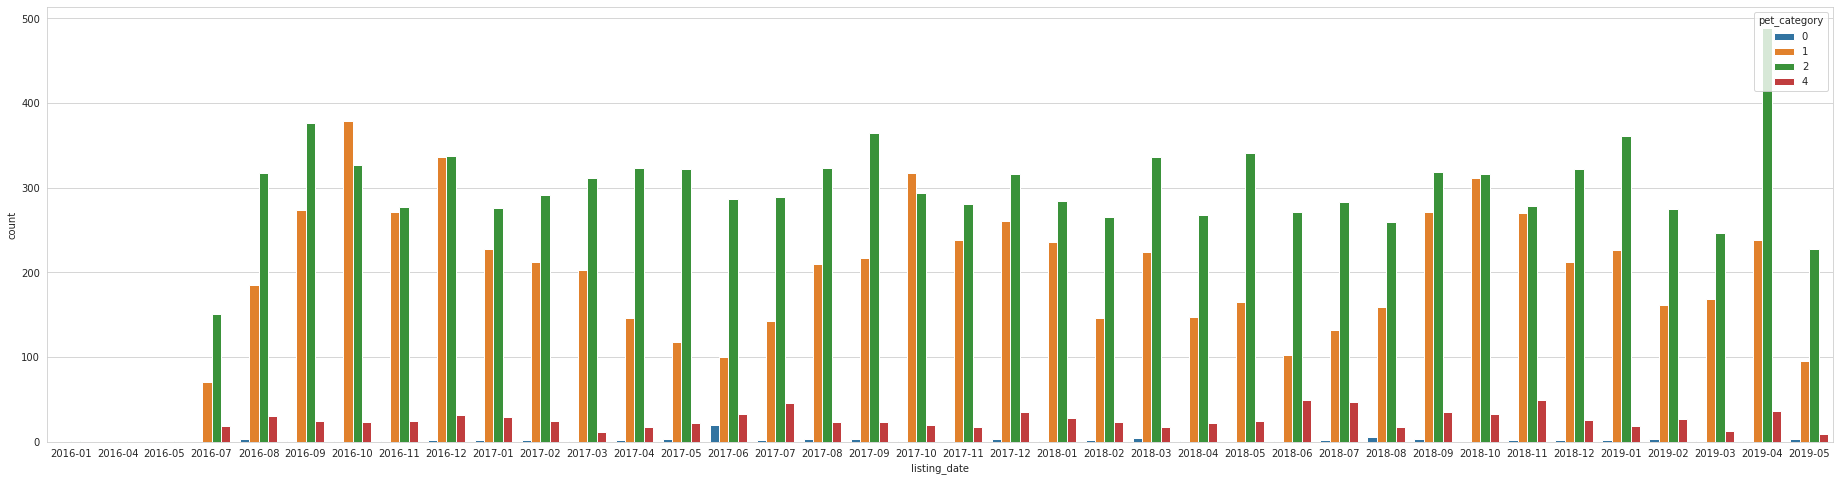

In [ ]:
date_plot('listing_date','pet_category')

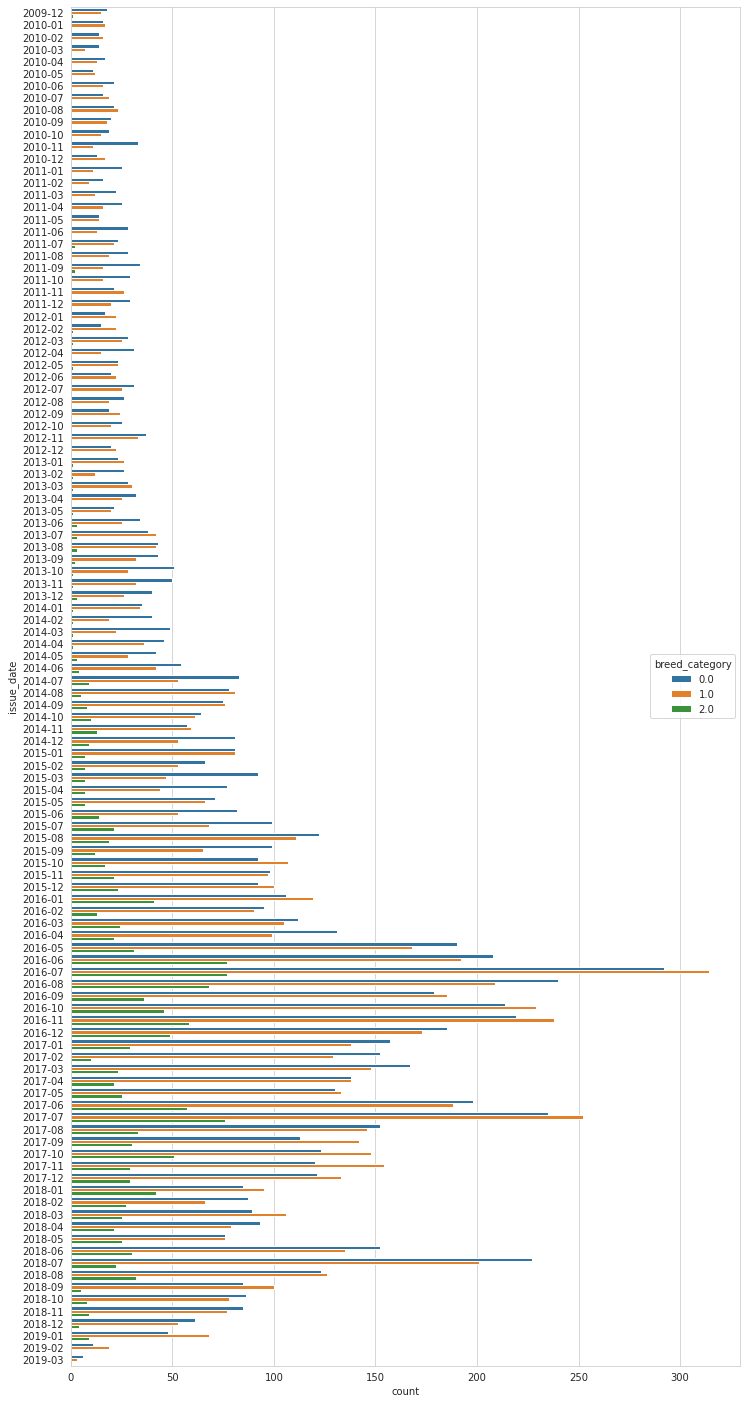

In [ ]:
date_plot('issue_date','breed_category', rot=False)

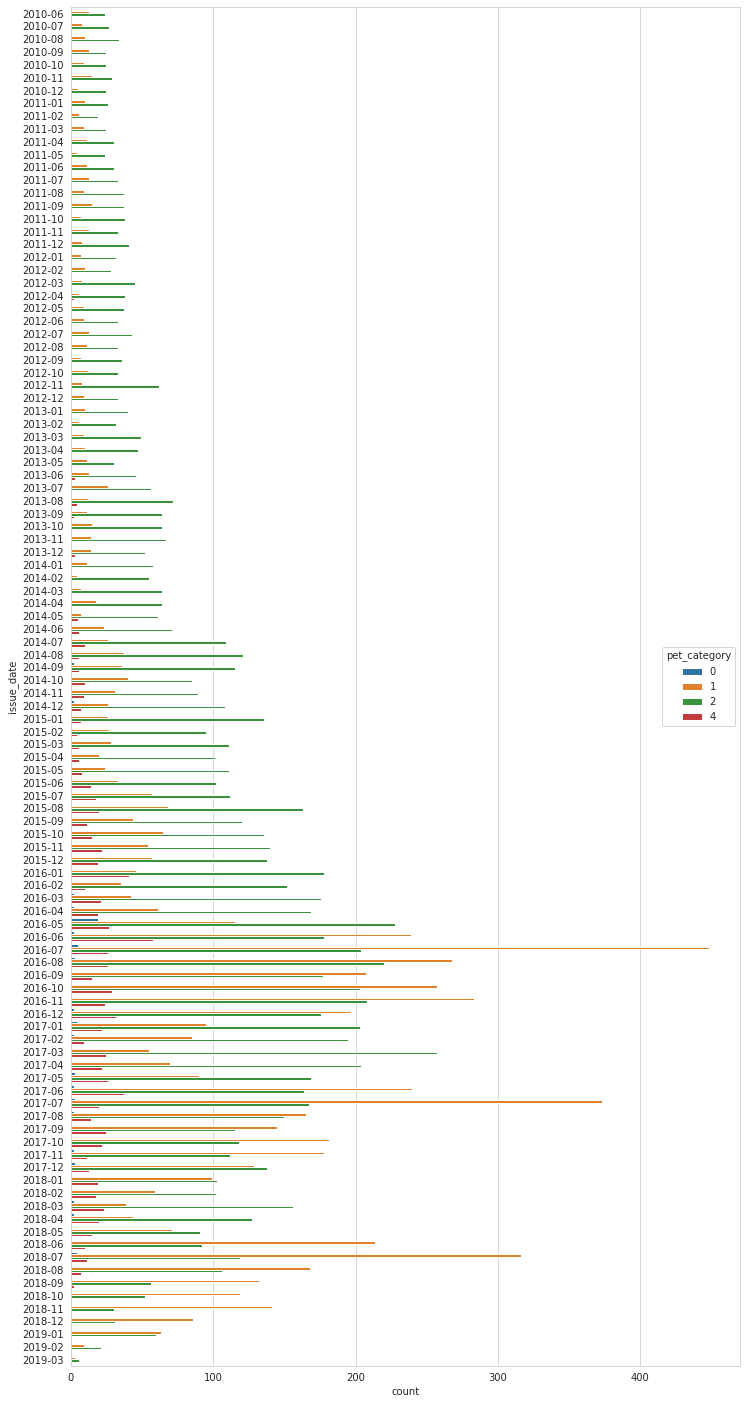

In [ ]:
date_plot('issue_date','pet_category', rot=False)

## Saving X_train , X_test

In [80]:
# combine train & test set for data preprocessing
X_train.shape, X_test.shape

((18834, 7), (8072, 7))

In [82]:
 combine_df=pd.concat([X_train, X_test], ignore_index=True)
 combine_df.shape

(26906, 7)

In [83]:
combine_df=pd.concat([combine_df.drop(['color_type'], axis=1), pd.get_dummies(combine_df['color_type'])], axis=1)
combine_df=pd.concat([combine_df.drop(['condition'], axis=1), pd.get_dummies(combine_df['condition'])], axis=1)
combine_df.head()

,height(cm),X1,X2,days,day_per_area,Agouti,Apricot,Black,Black Brindle,Black Smoke,Black Tabby,Black Tiger,Blue,Blue Cream,Blue Merle,Blue Point,Blue Smoke,Blue Tabby,Blue Tick,Blue Tiger,Brown,Brown Brindle,Brown Merle,Brown Tabby,Brown Tiger,Buff,Calico,Calico Point,Chocolate,Chocolate Point,Cream,Cream Tabby,Fawn,Flame Point,Gold,Gray,Gray Tabby,Green,Lilac Point,Liver,Liver Tick,Lynx Point,Orange,Orange Tabby,Pink,Red,Red Merle,Red Tick,Sable,Seal Point,Silver,Silver Lynx Point,Silver Tabby,Tan,Torbie,Tortie,Tortie Point,Tricolor,White,Yellow,Yellow Brindle,0.0,1.0,2.0
0,7.78,13,9,73,750.642674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,14.19,13,9,1862,9447.780127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,40.90,15,4,752,275.794621,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,17.82,0,1,755,2626.823793,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,11.06,18,4,52,235.081374,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [84]:
combine_df.shape

(26906, 64)

In [85]:
X_train=combine_df.iloc[:X_train.shape[0]]
X_test=combine_df.iloc[X_train.shape[0]:]

In [102]:
%cd /content/drive/My Drive/kaggle_data/Dataset

X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

/content/drive/My Drive/kaggle_data/Dataset


# Solving For Breed_category (target)

## Fitting data in Simple RAndom Forest Algo..

In [109]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train,Y_breed,test_size=0.105, random_state=222)
print(ytrain.value_counts())
ytest.value_counts()

0.0    8067
1.0    7478
2.0    1311
Name: breed_category, dtype: int64


0.0    933
1.0    879
2.0    166
Name: breed_category, dtype: int64

In [88]:
def fit(model, cv):
    return cross_val_score(model,X_train, Y_breed, cv=cv).mean()

100%|██████████| 64/64 [07:27<00:00,  7.00s/it]


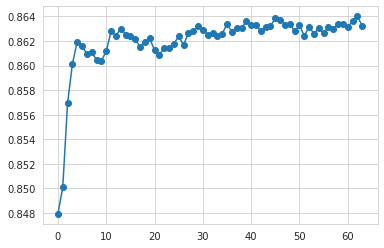

In [89]:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=222)
acc=[]
for i in tqdm(range(1,65)):
    clf=RandomForestClassifier(n_estimators=i, random_state=2001)
    acc.append(fit(clf,cv))
plt.grid(True)
plt.plot(acc ,marker='o')


## Optimize Hyperparameters
### Idea is to find best 3 parameters from *optuna* algo and then apply genetic algo
1. optuna

The hyperparameters of the above algorithm are n_estimators and max_depth for which we can try different values to see if the model accuracy can be improved. The objective function is modified to accept a trial object. This trial has several methods for sampling hyperparameters. We create a study to run the hyperparameter optimization and finally read the best hyperparameters.

2. Genetic Algorithms

Genetic Algorithms tries to apply natural selection mechanisms to Machine Learning contexts.

Let's immagine we create a population of N Machine Learning models with some predifined Hyperparameters. We can then calculate the accuracy of each model and decide to keep just half of the models (the ones that performs best). We can now generate some offsprings having similar Hyperparameters to the ones of the best models so that go get again a population of N models. At this point we can again caltulate the accuracy of each model and repeate the cycle for a defined number of generations. In this way, just the best models will survive at the end of the process.

### Optuna

In [106]:
X_train=pd.read_csv('/content/drive/My Drive/kaggle_data/Dataset/X_train.csv')
X_test=pd.read_csv('/content/drive/My Drive/kaggle_data/Dataset/X_test.csv')

In [130]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train,Y_breed,test_size=0.11, random_state=8882)
print(ytrain.value_counts())
ytest.value_counts()

0.0    8030
1.0    7411
2.0    1321
Name: breed_category, dtype: int64


0.0    970
1.0    946
2.0    156
Name: breed_category, dtype: int64

In [121]:
#import optuna

def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 2, 165)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))
    min_samples_split=int(trial.suggest_float('min_samples_split', 2, 20, log=True))
    min_samples_leaf=int(trial.suggest_float('min_samples_leaf', 2, 10, log=True))
    
    clf = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf)
    
    return sklearn.model_selection.cross_val_score(
        clf, xtrain, ytrain, n_jobs=-1, cv=5).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2020-08-03 08:22:57,792] Trial 0 finished with value: 0.8570578159266058 and parameters: {'n_estimators': 129, 'max_depth': 7.463272778259085, 'min_samples_split': 10.74614046329418, 'min_samples_leaf': 4.337027372964895}. Best is trial 0 with value: 0.8570578159266058.
[I 2020-08-03 08:22:59,148] Trial 1 finished with value: 0.8235892304615181 and parameters: {'n_estimators': 59, 'max_depth': 2.017534374905226, 'min_samples_split': 4.37857641911996, 'min_samples_leaf': 2.7917072934610587}. Best is trial 0 with value: 0.8570578159266058.
[I 2020-08-03 08:22:59,653] Trial 2 finished with value: 0.8143429422730473 and parameters: {'n_estimators': 15, 'max_depth': 2.3437206533601262, 'min_samples_split': 3.5354341587916367, 'min_samples_leaf': 6.132818957149839}. Best is trial 0 with value: 0.8570578159266058.
[I 2020-08-03 08:23:00,269] Trial 3 finished with value: 0.7524695228936863 and parameters: {'n_estimators': 26, 'max_depth': 1.617497120594716, 'min_samples_split': 2.1398312279

Accuracy: 0.8695265949988148
Best hyperparameters: {'n_estimators': 142, 'max_depth': 23.743224252767927, 'min_samples_split': 3.330404200067565, 'min_samples_leaf': 2.2708704766613663}


In [125]:
rf_clf2=RandomForestClassifier(n_estimators= 142, max_depth= 24, min_samples_split= 3)
rf_clf2.fit(xtrain,ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=142,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [133]:
y_pred=rf_clf.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[933  28   9]
 [ 42 895   9]
 [ 14  19 123]]
---------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       970
         1.0       0.95      0.95      0.95       946
         2.0       0.87      0.79      0.83       156

    accuracy                           0.94      2072
   macro avg       0.92      0.90      0.91      2072
weighted avg       0.94      0.94      0.94      2072

---------------------------
0.9416023166023166


In [132]:
rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [126]:
y_pred=rf_clf2.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[868  83  19]
 [101 828  17]
 [ 20  25 111]]
---------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       970
         1.0       0.88      0.88      0.88       946
         2.0       0.76      0.71      0.73       156

    accuracy                           0.87      2072
   macro avg       0.84      0.83      0.83      2072
weighted avg       0.87      0.87      0.87      2072

---------------------------
0.872104247104247


In [ ]:
# removing X12 feature
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 2, 265)
    max_depth = int(trial.suggest_int('max_depth', 1, 32, log=True))
    min_samples_split=int(trial.suggest_int('min_samples_split', 2, 20, log=True))
    min_samples_leaf=int(trial.suggest_int('min_samples_leaf', 2, 10, log=True))
    
    clf = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf)
    
    return sklearn.model_selection.cross_val_score(
        clf, xtrain.drop(['X12'], axis=1), ytrain, n_jobs=-1, cv=5).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2020-08-01 07:27:11,447] Trial 0 finished with value: 0.8550442477876107 and parameters: {'n_estimators': 150, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8550442477876107.
[I 2020-08-01 07:27:16,600] Trial 1 finished with value: 0.8419469026548672 and parameters: {'n_estimators': 188, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8550442477876107.
[I 2020-08-01 07:27:26,035] Trial 2 finished with value: 0.8510324483775811 and parameters: {'n_estimators': 264, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8550442477876107.
[I 2020-08-01 07:27:28,607] Trial 3 finished with value: 0.8582890855457226 and parameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8582890855457226.
[I 2020-08-01 07:27:35,854] Trial 4 finished with value: 0.8568141592920355 and parameters:

Accuracy: 0.8598230088495574
Best hyperparameters: {'n_estimators': 180, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2}


In [110]:
rf_clf=RandomForestClassifier(n_estimators= 180, max_depth= 24, min_samples_split= 2, min_samples_leaf=2)
rf_clf.fit(xtrain,ytrain)

y_pred=rf_clf.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[830  93  10]
 [ 88 778  13]
 [ 42  16 108]]
---------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88       933
         1.0       0.88      0.89      0.88       879
         2.0       0.82      0.65      0.73       166

    accuracy                           0.87      1978
   macro avg       0.86      0.81      0.83      1978
weighted avg       0.87      0.87      0.87      1978

---------------------------
0.8675429726996967


In [ ]:
# removing X12 feature
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 2, 265)
    max_depth = int(trial.suggest_int('max_depth', 1, 32, log=True))
    min_samples_split=int(trial.suggest_int('min_samples_split', 2, 20, log=True))
    min_samples_leaf=int(trial.suggest_int('min_samples_leaf', 2, 10, log=True))
    
    clf = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf)
    
    return sklearn.model_selection.cross_val_score(
        clf, xtrain.drop(['X12'], axis=1), ytrain, n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2020-08-01 07:47:54,285] Trial 0 finished with value: 0.8407695945818036 and parameters: {'n_estimators': 19, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8407695945818036.
[I 2020-08-01 07:47:54,919] Trial 1 finished with value: 0.8224597963080439 and parameters: {'n_estimators': 47, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8407695945818036.
[I 2020-08-01 07:47:56,969] Trial 2 finished with value: 0.8550505361039845 and parameters: {'n_estimators': 83, 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8550505361039845.
[I 2020-08-01 07:47:57,419] Trial 3 finished with value: 0.8147090652439489 and parameters: {'n_estimators': 27, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8550505361039845.
[I 2020-08-01 07:47:57,688] Trial 4 finished with value: 0.8487643358955136 and parameters: {'n_e

Accuracy: 0.859139638298919
Best hyperparameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2}


In [108]:
rf_clf=RandomForestClassifier(n_estimators= 200, max_depth= 30, min_samples_split= 2, min_samples_leaf=2)
rf_clf.fit(xtrain,ytrain)

y_pred=rf_clf.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[   0    0    5    1]
 [   0  763  150    1]
 [   0   80 1326    0]
 [   0    8   26   89]]
---------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.90      0.83      0.86       914
           2       0.88      0.94      0.91      1406
           4       0.98      0.72      0.83       123

    accuracy                           0.89      2449
   macro avg       0.69      0.63      0.65      2449
weighted avg       0.89      0.89      0.89      2449

---------------------------
0.8893425888117599


### Genetic Algo..

In [ ]:
|#from tpot import TPOTClassifier

In [ ]:
n_estimators = [11,180,200,210,166,73,89,107]
max_features = ['auto', 'sqrt','log2']
max_depth = [21,22,24,27,30,32,43]
min_samples_split = [2, 5, 9,14,11]
min_samples_leaf = [1, 2, 4,6,8]

param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}

              

In [ ]:
tpot_classifier = TPOTClassifier(generations= 6, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': param}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(xtrain,ytrain)


Generation 1 - Current best internal CV score: 0.8588349796487903
Generation 2 - Current best internal CV score: 0.8596284813726126
Generation 3 - Current best internal CV score: 0.8596284813726126
Generation 4 - Current best internal CV score: 0.8596284813726126
Generation 5 - Current best internal CV score: 0.8596284813726126

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), criterion=entropy, max_depth=27, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=11)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [21,
                                                                                      22,
                                                                                      24,
                                                                                      27,
                                                                                      30,
                                                                                      32,
                                                                                      43],
                                                                        'max_features': ['auto',
                                                                                

In [ ]:
y_pred=tpot_classifier.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[1045   84   10]
 [ 152  964   14]
 [  43   36  101]]
---------------------------
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88      1139
         1.0       0.89      0.85      0.87      1130
         2.0       0.81      0.56      0.66       180

    accuracy                           0.86      2449
   macro avg       0.85      0.78      0.80      2449
weighted avg       0.86      0.86      0.86      2449

---------------------------
0.8615761535320539


In [ ]:
print(tpot_classifier.export())

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8596284813726126
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    RandomForestClassifier(criterion="entropy", max_depth=27, max_features="sqrt", min_samples_leaf=4, min_samples_split=5, n_e

In [ ]:
clf=RandomForestClassifier(criterion="entropy", max_depth=27, max_features="sqrt", min_samples_leaf=4, min_samples_split=5, n_estimators=11)
clf.fit(xtrain,ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=27, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=11,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
breed_df=pd.DataFrame(tpot_classifier.predict(X_test), columns=['breed_category'])
breed_df.head()

,breed_category
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
%cd /content/drive/My Drive/kaggle_data/Dataset
breed_df.to_csv('breed_sol.csv') 

/content/drive/My Drive/kaggle_data/Dataset


### XGBoost

In [ ]:
xg_param={
    'n_estimators': [11,77,101,127, 81, 155, 189],
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.45],
    'max_depth': [3,4,5,7,9,10,11,13,15,27],
    'min_child_weight': [1,3,5,7,9],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.7],
    'booster':['gbtree', 'gblinear', 'dart']
}

xg_clf=xgboost.XGBClassifier()

In [ ]:
random=RandomizedSearchCV(xg_clf, param_distributions=xg_param, n_jobs=-1, cv=5, verbose=3, scoring='accuracy' )

random.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                  

In [ ]:
random.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2,
              learning_rate=0.2, max_delta_step=0, max_depth=11,
              min_child_weight=7, missing=None, n_estimators=11, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
final_xbg=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2,
              learning_rate=0.2, max_delta_step=0, max_depth=11,
              min_child_weight=7, missing=None, n_estimators=11, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#final_xgb.fit(xtrain,ytrain)

In [ ]:
final_xbg.fit(xtrain,ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2,
              learning_rate=0.2, max_delta_step=0, max_depth=11,
              min_child_weight=7, missing=None, n_estimators=11, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:

y_pred = final_xbg.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[838  86   9]
 [ 93 784   2]
 [ 44  38  84]]
---------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       933
         1.0       0.86      0.89      0.88       879
         2.0       0.88      0.51      0.64       166

    accuracy                           0.86      1978
   macro avg       0.87      0.77      0.80      1978
weighted avg       0.86      0.86      0.86      1978

---------------------------
0.8624873609706775


In [114]:
param={
    'n_estimators': [11,77,101,127, 189],
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25],
    'max_depth': [3,4,5,7,9,10,11,13,15,27],
    'min_child_weight': [1,3,5,7,9],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.7],
    'booster':['gbtree', 'gblinear', 'dart']
}

tpot_classifier = TPOTClassifier(generations= 4, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'xgboost.XGBClassifier': param}, 
                                 cv = 6, scoring = 'accuracy')
tpot_classifier.fit(xtrain,ytrain)


Generation 1 - Current best internal CV score: 0.8728671176868441
Generation 2 - Current best internal CV score: 0.8728671176868441
Generation 3 - Current best internal CV score: 0.8728671176868441

Best pipeline: XGBClassifier(CombineDFs(CombineDFs(input_matrix, input_matrix), input_matrix), booster=gbtree, colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=77)


TPOTClassifier(config_dict={'xgboost.XGBClassifier': {'booster': ['gbtree',
                                                                  'gblinear',
                                                                  'dart'],
                                                      'colsample_bytree': [0.3,
                                                                           0.4,
                                                                           0.5,
                                                                           0.7],
                                                      'gamma': [0.0, 0.1, 0.2,
                                                                0.3, 0.4],
                                                      'learning_rate': [0.05,
                                                                        0.1,
                                                                        0.15,
                                                               

In [115]:

y_pred = tpot_classifier.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[877  76  17]
 [116 818  12]
 [ 20  22 114]]
---------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88       970
         1.0       0.89      0.86      0.88       946
         2.0       0.80      0.73      0.76       156

    accuracy                           0.87      2072
   macro avg       0.85      0.83      0.84      2072
weighted avg       0.87      0.87      0.87      2072

---------------------------
0.8730694980694981


In [134]:
breed_df=pd.DataFrame(rf_clf.predict(X_test), columns=['breed_category'])
breed_df.head()

,breed_category
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


In [138]:
%cd /content/drive/My Drive/kaggle_data/Dataset
breed_df.to_csv('breed_sol_.csv', index=False) 

/content/drive/My Drive/kaggle_data/Dataset


# Solving for Pet_categoryn(target)

In [8]:
X_train=pd.read_csv('/content/drive/My Drive/kaggle_data/Dataset/X_train.csv')
X_test=pd.read_csv('/content/drive/My Drive/kaggle_data/Dataset/X_test.csv')

In [13]:
X_train.head()

,height(cm),X1,X2,days,day_per_area,Agouti,Apricot,Black,Black Brindle,Black Smoke,Black Tabby,Black Tiger,Blue,Blue Cream,Blue Merle,Blue Point,Blue Smoke,Blue Tabby,Blue Tick,Blue Tiger,Brown,Brown Brindle,Brown Merle,Brown Tabby,Brown Tiger,Buff,Calico,Calico Point,Chocolate,Chocolate Point,Cream,Cream Tabby,Fawn,Flame Point,Gold,Gray,Gray Tabby,Green,Lilac Point,Liver,Liver Tick,Lynx Point,Orange,Orange Tabby,Pink,Red,Red Merle,Red Tick,Sable,Seal Point,Silver,Silver Lynx Point,Silver Tabby,Tan,Torbie,Tortie,Tortie Point,Tricolor,White,Yellow,Yellow Brindle,0.0,1.0,2.0
0,7.78,13,9,73,750.642674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,14.19,13,9,1862,9447.780127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,40.90,15,4,752,275.794621,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,17.82,0,1,755,2626.823793,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,11.06,18,4,52,235.081374,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train,Y_pet,test_size=0.12, random_state=82)
print(ytrain.value_counts())
ytest.value_counts()

2    9325
1    6353
4     819
0      76
Name: pet_category, dtype: int64


2    1296
1     831
4     122
0      12
Name: pet_category, dtype: int64

In [15]:
import optuna

def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 2, 165)
    max_depth = int(trial.suggest_int('max_depth', 1, 32, log=True))
    min_samples_split=int(trial.suggest_int('min_samples_split', 2, 20, log=True))
    min_samples_leaf=int(trial.suggest_int('min_samples_leaf', 2, 10, log=True))
    
    clf = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf)
    
    return sklearn.model_selection.cross_val_score(
        clf, xtrain, ytrain, n_jobs=-1, cv=5).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2020-08-03 09:43:05,262] Trial 0 finished with value: 0.8809505448342467 and parameters: {'n_estimators': 101, 'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8809505448342467.
[I 2020-08-03 09:43:06,246] Trial 1 finished with value: 0.6467731485147794 and parameters: {'n_estimators': 52, 'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8809505448342467.
[I 2020-08-03 09:43:07,993] Trial 2 finished with value: 0.8551253196139419 and parameters: {'n_estimators': 40, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8809505448342467.
[I 2020-08-03 09:43:15,818] Trial 3 finished with value: 0.8862003238693926 and parameters: {'n_estimators': 102, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8862003238693926.
[I 2020-08-03 09:43:19,891] Trial 4 finished with value: 0.8763046484087343 and parameters: {'n

Accuracy: 0.8878897424064096
Best hyperparameters: {'n_estimators': 64, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2}


In [27]:
clf=RandomForestClassifier(n_estimators=64, max_depth=29, min_samples_leaf=2)
clf.fit(xtrain,ytrain)

y_pred=clf.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[   1    0    8    3]
 [   0  703  128    0]
 [   0   69 1226    1]
 [   0    3   34   85]]
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.91      0.85      0.88       831
           2       0.88      0.95      0.91      1296
           4       0.96      0.70      0.81       122

    accuracy                           0.89      2261
   macro avg       0.94      0.64      0.69      2261
weighted avg       0.89      0.89      0.89      2261

---------------------------
0.8911985846970367


In [ ]:
# Once again
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2020-08-01 10:09:13,802] Trial 0 finished with value: 0.7448275862068965 and parameters: {'n_estimators': 26, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7448275862068965.
[I 2020-08-01 10:09:17,465] Trial 1 finished with value: 0.8319804699420204 and parameters: {'n_estimators': 122, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8319804699420204.
[I 2020-08-01 10:09:17,933] Trial 2 finished with value: 0.6134269148611535 and parameters: {'n_estimators': 20, 'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8319804699420204.
[I 2020-08-01 10:09:26,730] Trial 3 finished with value: 0.8619469026548673 and parameters: {'n_estimators': 160, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8619469026548673.
[I 2020-08-01 10:09:29,475] Trial 4 finished with value: 0.8559658223985354 and parameters: {'n_e

Accuracy: 0.8657308513884651
Best hyperparameters: {'n_estimators': 59, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 2}


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2020-08-01 10:12:40,712] Trial 0 finished with value: 0.8055538602380226 and parameters: {'n_estimators': 61, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8055538602380226.
[I 2020-08-01 10:12:44,236] Trial 1 finished with value: 0.8335672871528838 and parameters: {'n_estimators': 121, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8335672871528838.
[I 2020-08-01 10:12:46,413] Trial 2 finished with value: 0.7639304241684468 and parameters: {'n_estimators': 108, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8335672871528838.
[I 2020-08-01 10:12:48,653] Trial 3 finished with value: 0.6325907842538908 and parameters: {'n_estimators': 160, 'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8335672871528838.
[I 2020-08-01 10:12:49,414] Trial 4 finished with value: 0.7091852303936527 and parameters: {'n_

Accuracy: 0.8654867256637168
Best hyperparameters: {'n_estimators': 133, 'max_depth': 29, 'min_samples_split': 11, 'min_samples_leaf': 2}


In [11]:
param={
    'n_estimators': [11,77,101,127, 189],
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25],
    'max_depth': [3,4,5,7,11,13,15,27],
    'min_child_weight': [1,3,5,7,9],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.7],
    'booster':['gbtree', 'gblinear', 'dart']
}

tpot_classifier2 = TPOTClassifier(generations= 4, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'xgboost.XGBClassifier': param}, 
                                 cv = 6, scoring = 'accuracy')
tpot_classifier2.fit(xtrain,ytrain)


Generation 1 - Current best internal CV score: 0.8979665957579334


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, booster=gbtree, colsample_bytree=0.4, gamma=0.4, learning_rate=0.15, max_depth=11, min_child_weight=3, n_estimators=101)

Best pipeline: XGBClassifier(input_matrix, booster=gbtree, colsample_bytree=0.4, gamma=0.4, learning_rate=0.15, max_depth=11, min_child_weight=3, n_estimators=101)


TPOTClassifier(config_dict={'xgboost.XGBClassifier': {'booster': ['gbtree',
                                                                  'gblinear',
                                                                  'dart'],
                                                      'colsample_bytree': [0.3,
                                                                           0.4,
                                                                           0.5,
                                                                           0.7],
                                                      'gamma': [0.0, 0.1, 0.2,
                                                                0.3, 0.4],
                                                      'learning_rate': [0.05,
                                                                        0.1,
                                                                        0.15,
                                                               

In [17]:
y_pred=tpot_classifier2.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[   1    0    8    3]
 [   0  711  120    0]
 [   0   63 1232    1]
 [   0    5   30   87]]
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.91      0.86      0.88       831
           2       0.89      0.95      0.92      1296
           4       0.96      0.71      0.82       122

    accuracy                           0.90      2261
   macro avg       0.94      0.65      0.69      2261
weighted avg       0.90      0.90      0.90      2261

---------------------------
0.8982750995134896


In [ ]:
clf=RandomForestClassifier(n_estimators= 133, max_depth= 29, min_samples_split= 11, min_samples_leaf= 2)
clf.fit(xtrain,ytrain)
y_pred=clf.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[   0    0    3    3]
 [   0  719  194    1]
 [   0   87 1319    0]
 [   0    7   25   91]]
---------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.88      0.79      0.83       914
           2       0.86      0.94      0.90      1406
           4       0.96      0.74      0.83       123

    accuracy                           0.87      2449
   macro avg       0.67      0.62      0.64      2449
weighted avg       0.87      0.87      0.87      2449

---------------------------
0.8693344222131483


In [ ]:
clf=RandomForestClassifier(n_estimators= 89, max_depth= 29, min_samples_split= 20, min_samples_leaf= 2)
#'n_estimators': 89, 'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 2
clf.fit(xtrain,ytrain)
y_pred=clf.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[   0    0    4    2]
 [   0  719  194    1]
 [   0   84 1322    0]
 [   0    8   25   90]]
---------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.89      0.79      0.83       914
           2       0.86      0.94      0.90      1406
           4       0.97      0.73      0.83       123

    accuracy                           0.87      2449
   macro avg       0.68      0.61      0.64      2449
weighted avg       0.87      0.87      0.87      2449

---------------------------
0.870151082074316


In [28]:
pet_df=pd.DataFrame(clf.predict(X_test), columns=['pet_category'])
pet_df.head()

,pet_category
0,2
1,1
2,2
3,2
4,2


In [19]:
%cd /content/drive/My Drive/kaggle_data/Dataset
pet_df.to_csv('pet_sol_.csv') 

/content/drive/My Drive/kaggle_data/Dataset


In [ ]:
param={
    'n_estimators': [11,77,101,127, 189],
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25],
    'max_depth': [3,4,5,7,9,10,11,13,15,27],
    'min_child_weight': [1,3,5,7,9],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.7],
    'booster':['gbtree', 'gblinear', 'dart']
}

tpot_classifier = TPOTClassifier(generations= 3, population_size= 16, offspring_size= 9,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'xgboost.XGBClassifier': param}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(xtrain,ytrain)


Generation 1 - Current best internal CV score: 0.8731771389507567
Generation 2 - Current best internal CV score: 0.8731771389507567

Best pipeline: XGBClassifier(input_matrix, booster=gbtree, colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=11, min_child_weight=1, n_estimators=189)


TPOTClassifier(config_dict={'xgboost.XGBClassifier': {'booster': ['gbtree',
                                                                  'gblinear',
                                                                  'dart'],
                                                      'colsample_bytree': [0.3,
                                                                           0.4,
                                                                           0.5,
                                                                           0.7],
                                                      'gamma': [0.0, 0.1, 0.2,
                                                                0.3, 0.4],
                                                      'learning_rate': [0.05,
                                                                        0.1,
                                                                        0.15,
                                                               

In [ ]:
y_pred = tpot_classifier.predict(xtest)
print(confusion_matrix(ytest,y_pred))
print('---------------------------')
print(classification_report(ytest,y_pred))
print('---------------------------')
print(accuracy_score(ytest.values,y_pred))

[[   0    0    3    3]
 [   0  722  191    1]
 [   0   77 1329    0]
 [   0    7   25   91]]
---------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.90      0.79      0.84       914
           2       0.86      0.95      0.90      1406
           4       0.96      0.74      0.83       123

    accuracy                           0.87      2449
   macro avg       0.68      0.62      0.64      2449
weighted avg       0.88      0.87      0.87      2449

---------------------------
0.8746427113107391


In [ ]:
pet_df=pd.DataFrame(tpot_classifier.predict(X_test), columns=['pet_category'])
pet_df.head()

,pet_category
0,2
1,1
2,2
3,1
4,2


In [ ]:
%cd /content/drive/My Drive/kaggle_data/Dataset
pet_df.to_csv('pet_sol_xg.csv')

/content/drive/My Drive/kaggle_data/Dataset


## Final output for upload :-)

In [29]:
F_test=pd.read_csv('/content/drive/My Drive/kaggle_data/Dataset/test.csv')
F_test.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2
0,ANSL_75005,2005-08-17 00:00:00,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7
1,ANSL_76663,2018-11-15 00:00:00,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1
2,ANSL_58259,2012-10-11 00:00:00,2018-04-02 16:51:00,1.0,Black,0.24,41.21,0,7
3,ANSL_67171,2015-02-13 00:00:00,2018-04-06 07:25:00,1.0,Black,0.29,8.46,7,1
4,ANSL_72871,2017-01-18 00:00:00,2018-04-26 13:42:00,1.0,Brown,0.71,30.92,0,7


In [30]:
pet_df.head()

,pet_category
0,2
1,1
2,2
3,2
4,2


In [31]:
breed_df=pd.read_csv('/content/drive/My Drive/kaggle_data/Dataset/breed_sol_.csv')
breed_df.head()

,breed_category
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


In [32]:
main_sol_df=pd.concat([F_test.pet_id, breed_df.astype('int32'), pet_df], axis=1, sort=False)
main_sol_df.head(20)

,pet_id,breed_category,pet_category
0,ANSL_75005,1,2
1,ANSL_76663,0,1
2,ANSL_58259,0,2
3,ANSL_67171,0,2
4,ANSL_72871,0,2
5,ANSL_64886,1,1
6,ANSL_73798,1,2
7,ANSL_53131,1,2
8,ANSL_66674,0,1
9,ANSL_55165,1,2


In [34]:
main_sol_df.to_csv('main_sol2.csv', index=False) 